In [3]:

import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras
import random
import numpy as np 
import pandas as pd
import glob
import cv2
import os
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
import skimage.io
import os
import tensorflow as tf
from keras import layers
from keras import Model
from os import getcwd
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D
from keras.layers import MaxPooling2D, Dropout,Flatten
from keras import backend as K
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.xception import preprocess_input
from keras.layers import Input, Conv2D, Dense, concatenate
from keras.models import Model


In [4]:
data_dir = Path('/content/XDNN AugDataset') 
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

val_dir = os.path.join(data_dir, 'Val')
train_malaria_dir = os.path.join(train_dir, 'COVID') 
train_uninfected_dir = os.path.join(train_dir, 'NON-COVID')
validation_malaria_dir = os.path.join(val_dir, 'COVID')
validation_uninfected_dir = os.path.join(val_dir, 'NON-COVID')
test_malaria_dir = os.path.join(test_dir, 'COVID') 
test_uninfected_dir = os.path.join(test_dir, 'NON-COVID')


train_malaria_fnames = os.listdir(train_malaria_dir)
train_uninfected_fnames = os.listdir(train_uninfected_dir)
validation_malaria_fnames = os.listdir(validation_malaria_dir)
validation_uninfected_fnames = os.listdir(validation_uninfected_dir)
test_malaria_fnames = os.listdir(test_malaria_dir)
test_uninfected_fnames = os.listdir(test_uninfected_dir)



print(len(train_malaria_fnames))
print(len(validation_malaria_fnames))
print(len(train_uninfected_fnames))
print(len(validation_uninfected_fnames))
print("Test Covid", len(test_malaria_fnames))
print("Test Noncovid", len(test_uninfected_fnames))


4010
200
3935
196
Test Covid 250
Test Noncovid 246


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224)
                                                    )
validation_datagen = ImageDataGenerator(rescale=1./255)
 

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

testGenerator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                         batch_size=16,
                                                                         class_mode='categorical',
                                                                         shuffle=False,
                                                                         target_size=(224,224))

Found 7945 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [9]:
def mini_block(filters, x):
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(x)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation(tf.keras.activations.swish)(bn)
  return act

def double_mini_block(filters, x):
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(x)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation(tf.keras.activations.swish)(bn)
  conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding='same')(act)
  bn = tf.keras.layers.BatchNormalization()(conv)
  act = tf.keras.layers.Activation(tf.keras.activations.swish)(bn)
  return act


def MFL_block(f,inp):
  block1 = mini_block(f,inp)
  block2 = MFL_block(f,inp)
  #concat
  c1 =  concatenate([block1, block2])
  #1x1 conv for parameter reduction
  conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
  block3 = mini_block(f,conv)
  #3x3 block from input
  block4 = mini_block(f,inp)
  c2 = concatenate([block3, block4])
  conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c2)
  return conv

def MFL_Net():
  inp = tf.keras.layers.Input(shape=(224,224,3))
  b1 = mini_block(16,inp)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(b1)
  p1 = MFL_block(16,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
  p2 = MFL_block(32,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p2)
  p3 = MFL_block(64,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p3)
  p4 = MFL_block(128,pool)
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p4)
  globavg = tf.keras.layers.GlobalAveragePooling2D()(pool)
  drop = tf.keras.layers.Dropout(rate=0.5)(globavg)
  out = tf.keras.layers.Dense(2, activation='softmax')(drop)
  model = tf.keras.Model(inputs=inp, outputs=out)
  model.compile(optimizer = Adam(lr=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
  return model

model = MFL_Net()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 224, 224, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 224, 224, 16) 64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 224, 224, 16) 0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.000001)
callbacks = [tf.keras.callbacks.ModelCheckpoint('SARS_CoV2_MFL_Net.hdf5', save_weights_only=True, save_best_only=True,
            mode='min'),tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_loss',factor=0.5, patience=4, min_lr=0.000000001)] 
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            epochs =50, verbose=1, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
249/249 [==============================] - 99s 266ms/step - loss: 0.4150 - acc: 0.8146 - val_loss: 1.7875 - val_acc: 0.5657
Epoch 2/50
249/249 [==============================] - 65s 259ms/step - loss: 0.3200 - acc: 0.8687 - val_loss: 0.5150 - val_acc: 0.7677
Epoch 3/50
249/249 [==============================] - 65s 259ms/step - loss: 0.2375 - acc: 0.9065 - val_loss: 0.4344 - val_acc: 0.7904
Epoch 4/50
249/249 [==============================] - 65s 259ms/step - loss: 0.1839 - acc: 0.9286 - val_loss: 0.1489 - val_acc: 0.9444
Epoch 5/50
249/249 [==============================] - 65s 259ms/step - loss: 0.1476 - acc: 0.9442 - val_loss: 1.1602 - val_acc: 0.7374
Epoch 6/50
249/249 [==============================] - 65s 259ms/step - loss: 0.1181 - acc: 0.9551 - val_loss: 0.4073 - val_acc: 0.9066
Epoch 7/50
249/249 [==============================] - 65s 259ms/step - loss: 0.0976 - acc: 0.9609 - val_loss: 4.2081 - val_acc: 0.5227
Epoch 8/50
249/249 [==============================] - 6

In [11]:
data_dir = Path('/content/XDNN AugDataset')
test_dir = os.path.join(data_dir, 'Test')
test_malaria_dir = os.path.join(test_dir, 'COVID') 
test_uninfected_dir = os.path.join(test_dir, 'NON-COVID')
test_malaria_fnames = os.listdir(test_malaria_dir)
test_uninfected_fnames = os.listdir(test_uninfected_dir)
print(len(test_malaria_fnames))
print(len(test_uninfected_fnames))

250
246


In [12]:

testGenerator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                         batch_size=16,
                                                                         class_mode='categorical',
                                                                         shuffle=False,
                                                                         target_size=(224,224))

Found 496 images belonging to 2 classes.


In [13]:

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 16
num_of_test_samples = 496
predictions = model.predict_generator(testGenerator)

y_pred = np.argmax(predictions, axis=1)

true_classes = testGenerator.classes

class_labels = list(testGenerator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(testGenerator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


['COVID', 'NON-COVID']
[[247   3]
 [  3 243]]
              precision    recall  f1-score   support

       COVID       0.99      0.99      0.99       250
   NON-COVID       0.99      0.99      0.99       246

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496



In [14]:
from sklearn.metrics import  f1_score,roc_auc_score, accuracy_score
f1_score(testGenerator.classes, y_pred)

0.9878048780487805

In [15]:
accuracy_score(testGenerator.classes, y_pred)

0.9879032258064516

In [16]:
roc_auc_score(testGenerator.classes, y_pred)

0.9879024390243902

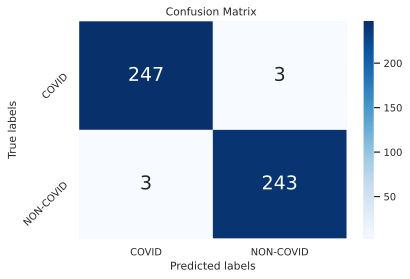

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
cm = confusion_matrix(testGenerator.classes, y_pred)

names = ["COVID", "NON-COVID"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=labels, fmt='', xticklabels= names, yticklabels= names, annot_kws={"size": 19}, cmap='Blues')
plt.yticks(rotation=45) 

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion Matrix ')
plt.savefig('cmxdnn98.78.svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()
from google.colab import files
files.download("cmxdnn98.78.svg")

In [18]:
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

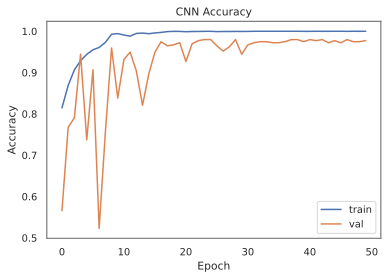

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best',facecolor="white")
plt.grid(b=None)

ax = plt.axes()
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

ax.set_facecolor("white")

plt.savefig('accxdnnswish98.78.svg',bbox_inches = 'tight', pad_inches = 0)
files.download("accxdnnswish98.78.svg")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

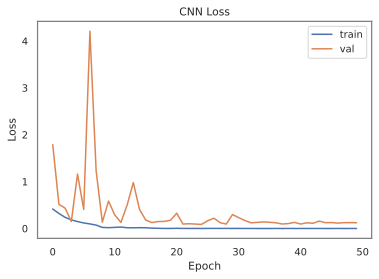

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='best',facecolor="white")
plt.grid(b=None)
ax = plt.axes()
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.patch.set_edgecolor('black')  

ax.set_facecolor("white")

plt.savefig("lossxdnnswish98.78.svg",bbox_inches = 'tight', pad_inches = 0)
files.download("lossxdnnswish98.78.svg")
plt.show()

In [22]:
tf.keras.models.save_model(model,'SARS_CoV2_MFL_Net.hdf5')

In [23]:
files.download("SARS_CoV2_MFL_Net.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>